# Diamond price prediction modeling - Machine Learning

## Objective: Train a Machine Learning model to predict the prices of the zircons

## Libraries

In [1]:
#data manipulation libraries
import pandas as pd
import numpy as np
import math
from datetime import datetime

#visualization libraries
import matplotlib.pyplot as plt

#machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

#metrics libraries
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#other libraries
import mlflow

c:\AI\Celsia\celsia\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data reading. Dataset is read for all exploratory analysis

In [2]:
df = pd.read_csv('../data/diamonds_df.csv')

## Feature Selection

In this section the most representative variables were selected using the technique of SelectKBest

In [13]:
#the X and Y variables are created to store the independent and dependent variables respectively.
x = df.drop(['price'],axis=1)
y = df['price']

In [14]:
#label encoding is used to convert categorical data, or text data, into numbers
label_encoder = LabelEncoder()
for col in x.select_dtypes(include=['object']).columns:
    x[col] = label_encoder.fit_transform(x[col])

In [15]:
#the data is standardized to used in the selectkbest algorithm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [16]:
#SelectKbest for regression is used to select the best features for regression problems. It is a univariate feature selection method. It works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.
selection = SelectKBest(score_func=mutual_info_regression,k='all')
selection.fit(X_scaled, y)
selection

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x00000265F09056C0>)

Feature 0: 1.959657
Feature 1: 0.104658
Feature 2: 0.283694
Feature 3: 0.361385
Feature 4: 0.036476
Feature 5: 0.056442


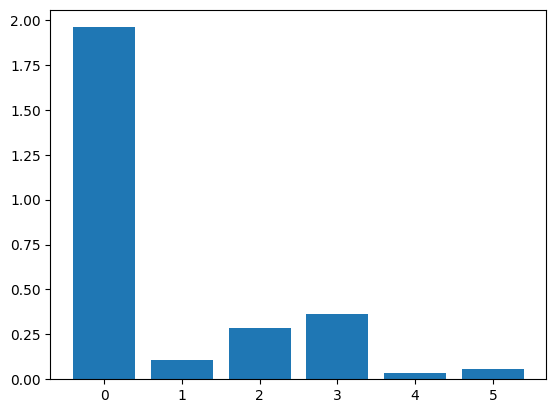

Text(0, 0.5, 'Variables')

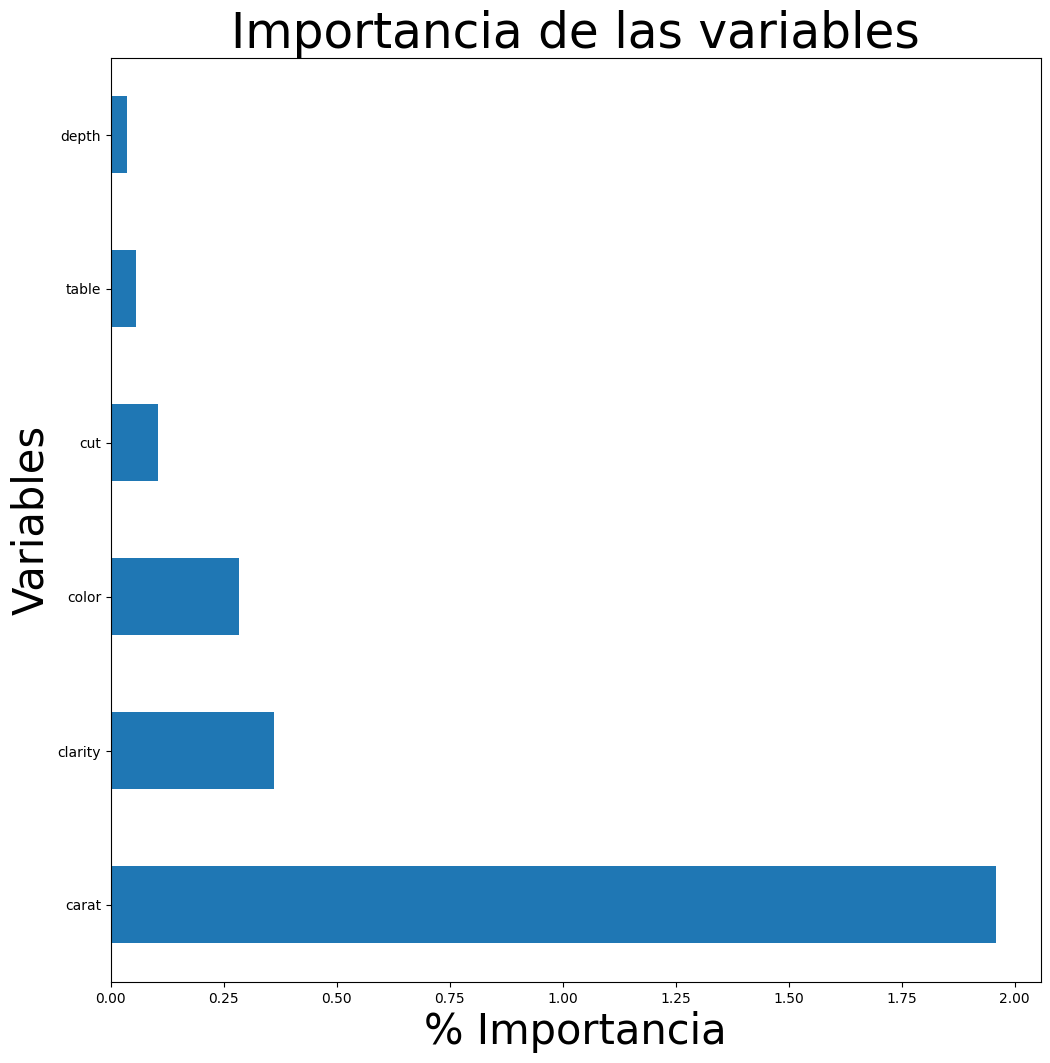

In [17]:
#This code is to plot the importance of the variables in the model calculated above
for i in range(len(selection.scores_)):
	print('Feature %d: %f' % (i, selection.scores_[i]))
plt.bar([i for i in range(len(selection.scores_))], selection.scores_)
plt.show()

plt.figure(figsize=(12,12),facecolor='w', edgecolor='k',num=1)
feat_importances = pd.Series(selection.scores_, index= x.columns)
feat_importances.nlargest(60).plot(kind='barh')
parameters = {'axes.labelsize': 50,
          'axes.titlesize':50}
plt.rcParams.update(parameters)
plt.title('Importancia de las variables',fontsize=35)
plt.xlabel('% Importancia', fontsize=30)
plt.ylabel('Variables', fontsize=30)

The most representative variable is carat, however all the variables have certaing percentage of importance respective the price, for that reason I going to keep all the variable for the modeling

## Feature Engineering

In this section, feature engineering techniques will be used to transform the variables to a point that allows better performance in the models that will later be trained.

#### X: Independient features
#### Y: Target feature (price)

In [3]:
#X and Y are defined. X are the features and Y is the target variable.
X = df.drop(['price'],axis=1)
Y = df['price']

### One Hot encoding technique

OneHotEncoder is used to encode categorical features as a one-hot numeric array

In [4]:
#OneHotEncoder is used to encode categorical features as a one-hot numeric array. This is necesary for the model to be able to train on the data.
columns_to_fit = [variable for variable in X.columns if X[variable].dtype == 'object']
enc = OneHotEncoder(sparse=False, drop='if_binary').fit(df.loc[:, columns_to_fit])

c:\AI\Celsia\celsia\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
#I save the encoder using joblib in the deploy folder
joblib.dump(enc, 'deploy/files/encoder.pkl')

['encoder.pkl']

In [5]:
#The following code is used to encode categorical variables using one-hot encoding trained before
column_names = enc.get_feature_names_out(columns_to_fit)
encoded_variables = pd.DataFrame(enc.transform(df.loc[:, columns_to_fit]), columns=column_names)
df = df.drop(columns_to_fit, axis=1)
df = pd.concat([df, encoded_variables], axis=1)

In [6]:
#The X and Y is redefined here with the categorical variables transformed to numerical values
X = df.drop(['price'],axis=1)
Y = df['price']

### Data Scaling

The X values are scaled in a range between 0 and 1 using Min Max Scaler technique

In [7]:
#The X values are scaled between 0 and 1 inclusive using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)

In [25]:
#The scaler is saved in the deploy folder
joblib.dump(scaler, 'deploys/files/scaler.pkl')

['scaler.pkl']

In [8]:
#New X set is generated with the values scaled
norm = scaler.transform(X)
#Is needed to create a new dataframe with the scaled values and the same columns as the original dataframe.
x_norm = pd.DataFrame(norm,index=df.index,columns=X.columns)

### Train Test Split

The training and testing data is split into 80% and 20% respectively

In [9]:
#The training and testing data is split into 80% and 20% respectively.
X_train, X_test, y_train, y_test = train_test_split(x_norm, Y, test_size=0.20,random_state=42)

## Machine Learning Modeling

The next class called RegressionModelTrainer has several methods to train different machine learning models with their respective hyperparameter tuning. Also has other methods to generate the predictions, metrics, and save the results

In [49]:
class RegressionModelTrainer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

#Decision Tree Regressor model with GridSearchCV for hyperparameter tuning
    def training_decision_tree(self):
        model = DecisionTreeRegressor()
        #Hyperparameter tuning
        min_samples_leaf = [2,5,10,15,20]
        max_depth = [None,3,5,8,10,12]
        param_grid = dict(min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
        grid.fit(X_train,y_train)
        return grid

#Random Forest Regressor model with GridSearchCV for hyperparameter tuning
    def training_random_forest(self):
        model = RandomForestRegressor()
        #Hyperparameter tuning
        n_estimators = [10,15,20,50,100]
        max_depth = [None,3,5,8,10,12]
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}
        grid = GridSearchCV(estimator=model, param_grid=random_grid, n_jobs=-1, cv=2)
        grid.fit(X_train,y_train)
        return grid

#Gradient Boosting Regressor model with GridSearchCV for hyperparameter tuning
    def training_gradient_boosting(self):
        model = GradientBoostingRegressor()
        #Hyperparameter tuning
        n_estimators = [10,15,20,50,100]
        max_depth = [None,3,5,8,10,12]
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}
        grid = GridSearchCV(estimator=model, param_grid=random_grid, n_jobs=-1, cv=2)
        grid.fit(X_train,y_train)
        return grid

#Support Vector Regressor model with GridSearchCV for hyperparameter tuning
    def training_svm(self):
        model = SVR()
        #Hyperparameter tuning
        kernel = ['linear', 'poly', 'rbf']
        C = [0.1, 1, 10]
        random_grid = {'kernel': kernel,
                    'C': C}
        grid = GridSearchCV(estimator=model, param_grid=random_grid, n_jobs=-1, cv=2)
        grid.fit(X_train,y_train)
        return grid

#K-Nearest Neighbors Regressor model with GridSearchCV for hyperparameter tuning
    def training_knn(self):
        model = KNeighborsRegressor()
        #Hyperparameter tuning
        n_neighbors = [3,5,8,10,12]
        random_grid = {'n_neighbors': n_neighbors}
        grid = GridSearchCV(estimator=model, param_grid=random_grid, n_jobs=-1, cv=2)
        grid.fit(X_train,y_train)
        return grid

#Linear Regression model with GridSearchCV for hyperparameter tuning
    def training_linear_regression(self):
        model = LinearRegression()
        #Hyperparameter tuning
        grid = GridSearchCV(estimator=model, param_grid={}, n_jobs=-1, cv=2)
        model.fit(X_train,y_train)
        grid.fit(X_train,y_train)
        coef = model.coef_
        intercept = model.intercept_
        return grid, coef, intercept

#Method to generate predictions with the model passed by parameter
    def prediction(self, model):
        #prediction for train data
        y_pred_train = model.predict(X_train)
        #prediction for test data
        y_pred_test = model.predict(X_test)
        return y_pred_train, y_pred_test

#Method to generate metrics for predictions passed by parameter
    def metrics(self, y_pred_train, y_pred_test):
        #mean squared error
        m1 = math.sqrt(mean_squared_error(y_train, y_pred_train))
        m2 = math.sqrt(mean_squared_error(y_test, y_pred_test))
        #mean absolute error
        m3 = mean_absolute_error(y_train, y_pred_train)
        m4 = mean_absolute_error(y_test, y_pred_test)
        #r2 score
        m5 = r2_score(y_train,y_pred_train)
        m6 = r2_score(y_test,y_pred_test)
        return {'RMSE_train': m1, 'RMSE_test': m2, 'MAE_train': m3, 'MAE_test': m4, 'R2_train': m5, 'R2_test': m6}

#Method to generate a graph with the predictions vs real values for the model and predictions passed by parameter
    def graph_loss(self, model, y_pred_train, y_pred_test):
        fig, ax = plt.subplots()
        ax.scatter(y_test, y_pred_test, edgecolors=(0, 0, 0))
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
        ax.set_xlabel('Actual values', fontsize=15)
        ax.set_ylabel('Predicted values', fontsize=15)
        ax.set_title('Actual values vs predicted value', fontsize=20)
        name = str(model.__dict__['estimator'])
        #the graph is saved in the images folder
        plt.savefig(f'images/{name}.png')

#Method to save the model passed by parameter
    def save_model(self, model):
        joblib.dump(model, 'deploy/files/model.pkl')
        return 'model saved'

Next I will create an instance of the class, and I going to apply each Algorith to that object as well the other methods such as metrics and loss graph

In [50]:
trainer = RegressionModelTrainer(X_train, X_test, y_train, y_test)

### Linear Regression

In [51]:
linear_regression_grid, _, _ = trainer.training_linear_regression()

In [52]:
pred_train, pred_test = trainer.prediction(linear_regression_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 1155.055819863827,
 'RMSE_test': 1159.5812535295936,
 'MAE_train': 806.4279060066741,
 'MAE_test': 802.723396366333,
 'R2_train': 0.916194984826261,
 'R2_test': 0.915415249038309}

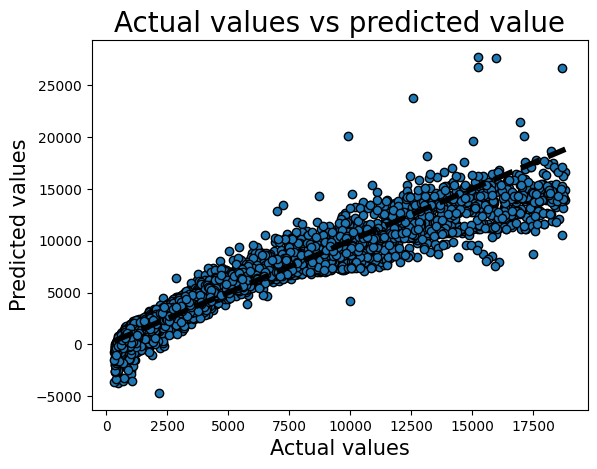

In [53]:
metrics_linear_reg = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(linear_regression_grid,pred_train, pred_test)

The results show that the Linear Regression has a good fit, however it is one of the simplest algorithms, so we will try the others

In [54]:
_, coef, intercep = trainer.training_linear_regression()
print("Coefficients: ", coef, "\nIntercept: ", intercep)

Coefficients:  [ 4.28452947e+04 -1.42983392e+02 -2.49036887e+02  1.62849594e+16
  1.62849594e+16  1.62849594e+16  1.62849594e+16  1.62849594e+16
  9.73954030e+14  9.73954030e+14  9.73954030e+14  9.73954030e+14
  9.73954030e+14  9.73954030e+14  9.73954030e+14  3.15571486e+15
  3.15571486e+15  3.15571486e+15  3.15571486e+15  3.15571486e+15
  3.15571486e+15  3.15571486e+15  3.15571486e+15] 
Intercept:  -2.0414628280316424e+16


Something very good about this algorithm is that we can see the parameters and how we know the math model of the Linear Regression (y = aX + b), we can build the formula to know the price of a diamond in a parametric way.

### Decision Trees

In [55]:
decision_tree_grid = trainer.training_decision_tree()
pred_train, pred_test = trainer.prediction(decision_tree_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 495.31252030462656,
 'RMSE_test': 609.5738636993102,
 'MAE_train': 260.6016799198218,
 'MAE_test': 312.918344767517,
 'R2_train': 0.9845892890130954,
 'R2_test': 0.9766254973395413}

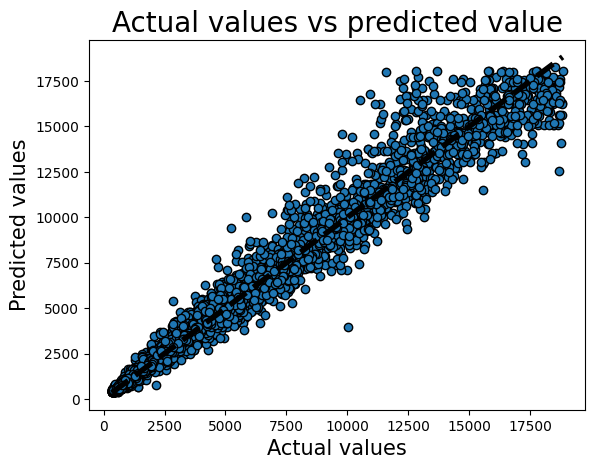

In [57]:
metrics_decision_tree = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(decision_tree_grid, pred_train, pred_test)

The results show that the Decision Tree has a much better performance that the Linear Regression, which is reasonable since it is an algorithm that not only detects linear relationships it does the Linear Regression. Also we can se that the algorithm doesn't overfit because the performance is similar with the train data and test data

### Random Forest

In [58]:
random_forest_grid = trainer.training_random_forest()
pred_train, pred_test = trainer.prediction(random_forest_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 362.8588243220892,
 'RMSE_test': 550.5916122733543,
 'MAE_train': 191.09161195846585,
 'MAE_test': 279.11077304228337,
 'R2_train': 0.9917293538225815,
 'R2_test': 0.9809300793598741}

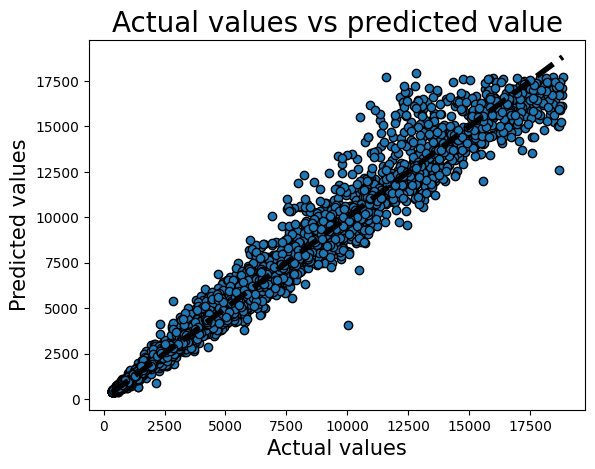

In [59]:
metrics_random_forest = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(random_forest_grid, pred_train, pred_test)

The results show that the Random Forest is the model that so far it's the best according with the metrics. 

In [ ]:
trainer.save_model(random_forest_grid)

We save the model to be used later for estimations

### Gradient Boosting

In [60]:
gradient_boosting_grid = trainer.training_gradient_boosting()
pred_train, pred_test = trainer.prediction(gradient_boosting_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 409.0540405520828,
 'RMSE_test': 539.8038179257952,
 'MAE_train': 226.41807106675515,
 'MAE_test': 274.0443727818186,
 'R2_train': 0.9894894501233416,
 'R2_test': 0.9816700361930418}

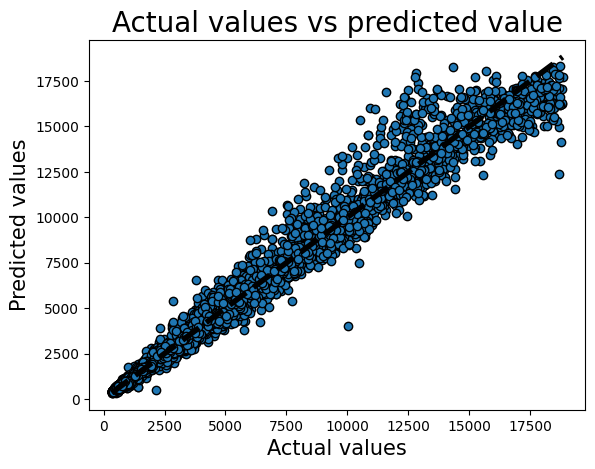

In [61]:
metrics_gradient_boosting = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(gradient_boosting_grid, pred_train, pred_test)

The Gradient Boosting shows results similar to Random Forest, being a little worse in its performance

### Support Vector Machine

In [62]:
svm_grid = trainer.training_svm()
pred_train, pred_test = trainer.prediction(svm_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 2194.396313160921,
 'RMSE_test': 2173.667562254114,
 'MAE_train': 1111.3236122894214,
 'MAE_test': 1086.3992905323778,
 'R2_train': 0.6975217208866056,
 'R2_test': 0.7027814217023014}

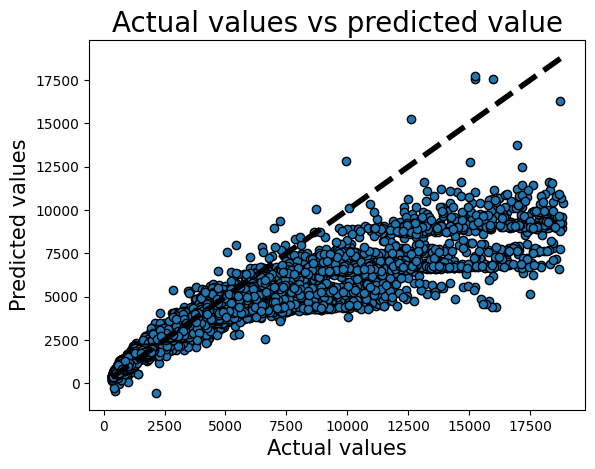

In [63]:
metrics_svm = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(svm_grid, pred_train, pred_test)

The SVM doesn't show a good performance, it's possible that we may need to try with more hyperparameters

### K-nearest neighbor

In [64]:
knn_grid = trainer.training_knn()
pred_train, pred_test = trainer.prediction(knn_grid)
trainer.metrics(pred_train, pred_test)

{'RMSE_train': 1010.556706811337,
 'RMSE_test': 1500.1615511714565,
 'MAE_train': 536.9023760968978,
 'MAE_test': 811.6300519095291,
 'R2_train': 0.9358516572347976,
 'R2_test': 0.8584317823211867}

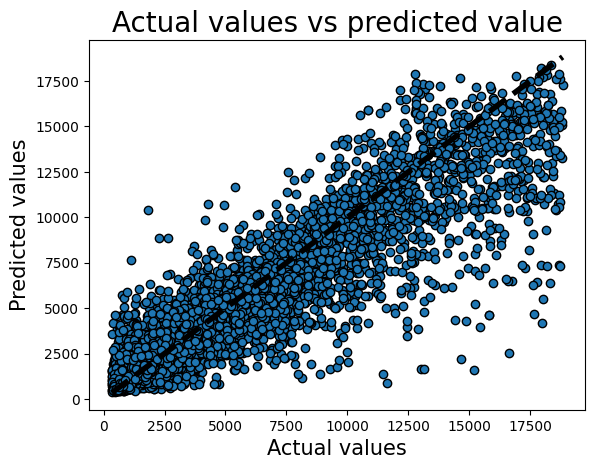

In [65]:
metrics_knn = trainer.metrics(pred_train, pred_test)
trainer.graph_loss(knn_grid, pred_train, pred_test)

This model shows overfiting, that could be because the number of the hyperparameter K (neighbors) is not the correct 

## MLFlow to track the experiments

Next, a function is defined to generate instances in MLFlow in order to record the experiments previously carried out with each of the Machine Learning models together with their respective results.

The function register the model used, the metrics obtained for each model, and the graph generated

In [66]:
#This function is used to log the model to mlflow
def create_experiment(experiment_name,run_name, run_metrics,model, plot_path = None, run_params=None):

    #mlflow instance is created
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):

        #Parameters and metrics are logged
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
            
        if not plot_path== None:
            mlflow.log_artifact(plot_path, "plot_path")
        
        #Model is logged and tags are set
        mlflow.set_tag("tag1", experiment_name)
        mlflow.set_tags({"tag2":run_name, "tag3":"Hyperparameter tuning"})
        mlflow.sklearn.log_model(model, "model")
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))


The function will be called for each experiment done with the Machine Learning models

In [68]:
experiment_name = "Linear Regression"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_linear_reg,linear_regression_grid,'LinearRegression().png')

2023/08/20 18:47:23 INFO mlflow.tracking.fluent: Experiment with name 'Linear Regression' does not exist. Creating a new experiment.


Run - Price prediction_20-08-23 is logged to Experiment - Linear Regression


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [69]:
experiment_name = "Decision Tree"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_decision_tree,decision_tree_grid,'DecisionTreeRegressor().png')

2023/08/20 18:48:25 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree' does not exist. Creating a new experiment.


Run - Price prediction_20-08-23 is logged to Experiment - Decision Tree


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [70]:
experiment_name = "Random Forest"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_random_forest,random_forest_grid,'RandomForestRegressor().png')

2023/08/20 18:49:29 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest' does not exist. Creating a new experiment.


Run - Price prediction_20-08-23 is logged to Experiment - Random Forest


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [72]:
experiment_name = "Gradient Boosting"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_gradient_boosting,gradient_boosting_grid,'images/GradientBoostingRegressor().png')

Run - Price prediction_20-08-23 is logged to Experiment - Gradient Boosting


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [73]:
experiment_name = "Support Vector Machine"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_svm,svm_grid,'images/SVR().png')

2023/08/20 18:56:25 INFO mlflow.tracking.fluent: Experiment with name 'Support Vector Machine' does not exist. Creating a new experiment.


Run - Price prediction_20-08-23 is logged to Experiment - Support Vector Machine


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [76]:
experiment_name = "k nearest neighbors"
run_name="Price prediction_"+str(datetime.now().strftime("%d-%m-%y"))
create_experiment(experiment_name,run_name,metrics_knn, knn_grid,'images/KNeighborsRegressor().png')

Run - Price prediction_20-08-23 is logged to Experiment - k nearest neighbors


c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\AI\Celsia\celsia\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


To execute and see all the experiments must run mlflow ui in the CLI

## Deep Neural Network

Next, a Deep Neural Network will be trained for the prediction task using Pytorch as a framework

In [78]:
#Class for the neural network model with the constructor and the forward method.
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
    
    #the forward method is used to define the forward pass of the neural network. 
    #The activation function used is ReLU.
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [71]:
input_size = 23 # number of features
output_size = 1  # number of nodes in output layer (=1 as we predict a single value)

#I'm using GPU so I need to send the model to the GPU to optimize the training
#I check if GPU is available and if not I use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
#Function to calculate RMSE (Root Mean Squared Error)
def rmse_loss(predictions, targets):
    mse = nn.MSELoss()(predictions, targets)
    rmse = torch.sqrt(mse)
    return rmse

In [74]:
def objective(trial):
    #Hyperparameters to optimize using optuna
    hidden_size1 = trial.suggest_int('hidden_size1', 23, 224)
    hidden_size2 = trial.suggest_int('hidden_size2', 23,224)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    batch_size = trial.suggest_int('batch_size', 12, 64)
    num_epoch = trial.suggest_int('num_epoch', 12, 64)
    
    #The model is defined with the hyperparameters optimized
    model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
    model.to(device)
    
    #if the optimizer is Adam, the learning rate is optimized using Adam, if not, SGD is used
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    #The training data is converted to tensors and sent to the GPU
    X_train_torch = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
    
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    
    #The training data is loaded in batches
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    #The model is trained with the training data and the loss is calculated using RMSE
    num_epochs = num_epoch
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = rmse_loss(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return loss.item()

In [75]:
if __name__ == "__main__":
    #The study is created and the objective function is optimized with 20 trials
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=20)
    
    #The best trial is printed
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2023-08-29 08:52:29,174] A new study created in memory with name: no-name-dda8c6b8-24dd-4438-b018-decc988884e5
C:\Users\pc\AppData\Local\Temp\ipykernel_19972\1268307043.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-08-29 08:55:41,758] Trial 0 finished with value: 557.023681640625 and parameters: {'hidden_size1': 106, 'hidden_size2': 52, 'learning_rate': 0.00019606934283988368, 'optimizer': 'Adam', 'batch_size': 42, 'num_epoch': 54}. Best is trial 0 with value: 557.023681640625.
[I 2023-08-29 08:58:03,040] Trial 1 finished with value: 3938.573974609375 and parameters: {'hidden_size1': 83, 'hidden_size2': 23, 'learning_rate': 2.2455449925815566e-05, 'optimizer': 'Adam', 'batch_size': 41, 'num_epoch': 39}. Best is trial 0 with value: 557.0236816

Number of finished trials:  20
Best trial:
Value:  156.29656982421875
Params: 
    hidden_size1: 183
    hidden_size2: 180
    learning_rate: 0.0023841597477206977
    optimizer: SGD
    batch_size: 37
    num_epoch: 34


## Conclusion

Even when the Deep neural network was the best model, for this case I would select a simple machine learning algotihm for deloy. The best machine learning model obtained is Random Forest with the next metrics :

RMSE: 362.8588243220892

R2: 0.9917293538225815